Test notebook for the nn distance. Contains the old version of the distance.

In [1768]:
import os
import torch
import json
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

from pandas.plotting import scatter_matrix
from scipy.spatial import distance
from scipy.stats import percentileofscore



The aim of this notebook is to look at the position of a nearest neighbour in another latent space (constructed with the same data):

- take a vector idx in a latent space A and find its nearest neighbour (nn)
- calculate the distance between idx and nn in a latent space B. (B is supposed to contain the representation of the same elements than in A.)
- rank nn in terms of distance to idx in B (it is first if it is still the closest to idx in B and last if it is the furthest)
- do stats on that

This is a proxy to see if the structure of a latent space is conserved from one to another (a couple of points that are close in a latent space souldn't be too far in the other one).

To use this notebook, you have to set up the paths to the csv files in the next code cell, then you can just Run All.

# Load the data

In [1769]:
def load_embeddings(path1, path2, verbose=False):    
    # load embeddings
    embeddings1 = pd.read_csv(path1, index_col=0)
    embeddings2 = pd.read_csv(path2, index_col=0)

    if verbose:
        print(embeddings1.head())
        print(embeddings2.head())

        print((embeddings1.index == embeddings2.index).all())

    return embeddings1, embeddings2

# choose models by hand
#dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/pca/4"
#path1 = dir_path + "/Run1/pca_embeddings.csv"
#path2 = dir_path + "/Run2/pca_embeddings.csv"

# choose random models with same conditions
def choose_random_models(dir_path):
    list_models = [file for file in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,file))]
    mod1, mod2 = rd.choice(list_models, size=2, replace=False)
    mod1, mod2 = np.sort([mod1, mod2])
    print("chosen_models", mod1, mod2)
    return mod1, mod2


dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
model_type = 'convnet'
conditions = 'no_foldlabel_30'
full_dir_path = os.path.join(dir_path, model_type, conditions)


mod1, mod2 = choose_random_models(full_dir_path)


## store the graphs and values (or not)
#save_path = None

save_path = os.path.join(dir_path, "#performance_comparisons/nn", model_type+'_'+conditions)
if not os.path.exists(save_path):
    os.mkdir(save_path)


# don't do twice the same thing
if save_path:
    while os.path.exists(os.path.join(save_path, mod1+'_'+mod2+".png")):
        mod1, mod2 = choose_random_models(full_dir_path)


path1 = os.path.join(full_dir_path, mod1, "cingulate_ACCpatterns_embeddings/full_embeddings.csv")
path2 = os.path.join(full_dir_path, mod2, "cingulate_ACCpatterns_embeddings/full_embeddings.csv")


embeddings1, embeddings2 = load_embeddings(path1, path2, verbose=True)

if embeddings1.shape[1] != embeddings2.shape[1]:
    raise ValueError("The two chosen embeddings haven't the same dimensions.")

n_dims = embeddings1.shape[1]
print(n_dims)

chosen_models 13-15-48 13-53-05
chosen_models 12-13-53 13-53-05
chosen_models 12-13-53 2022-07-05
                   dim1       dim2       dim3       dim4       dim5  \
ID                                                                    
1-15LEHMI_t0   4.449478  16.748594  30.547764 -22.644270  -1.274597   
1-17COLMA_t0  18.867954  34.619198  43.365326 -13.315820 -19.979673   
1-18ROUCO_t0  43.891117 -28.639128  27.363247 -50.896614 -65.859910   
1-40AYMJU_t0 -36.136720  28.177956  44.647650 -13.030479  35.706400   
2-02FERMA_t0 -13.452292   3.432962  13.269778  27.949810  13.329447   

                   dim6       dim7       dim8       dim9      dim10  ...  \
ID                                                                   ...   
1-15LEHMI_t0   2.111366  -3.990535  -8.236629  17.312319  37.839287  ...   
1-17COLMA_t0  -1.028698  10.715113 -21.144869  31.468853  25.399958  ...   
1-18ROUCO_t0 -37.280550 -28.605593 -55.350660   5.856234  -0.820465  ...   
1-40AYMJU_t0 -10.065201 

# Plot the scatter matrices of the two df

Only the four first dimensions

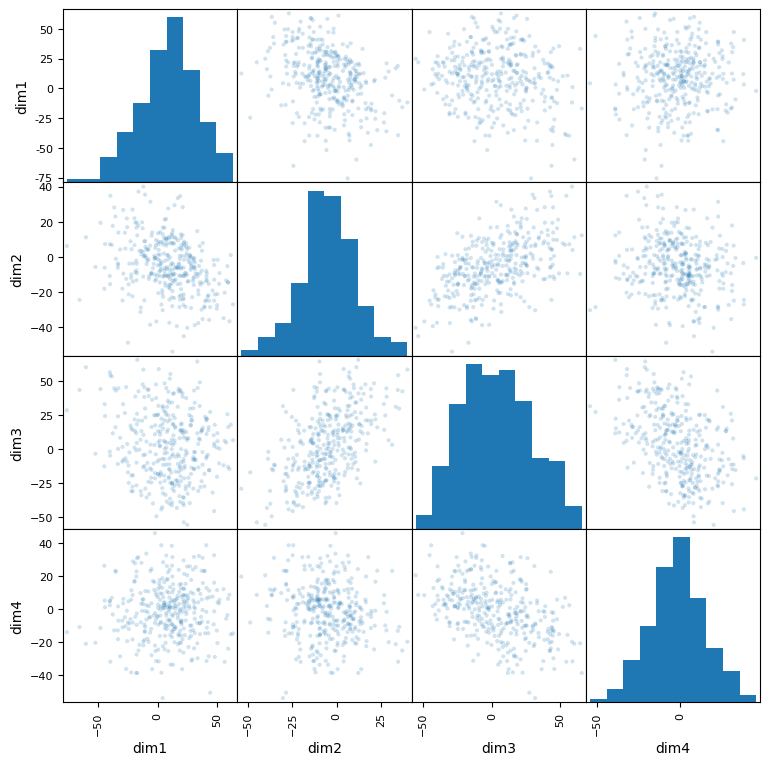

In [1770]:
sm1 = scatter_matrix(embeddings1[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

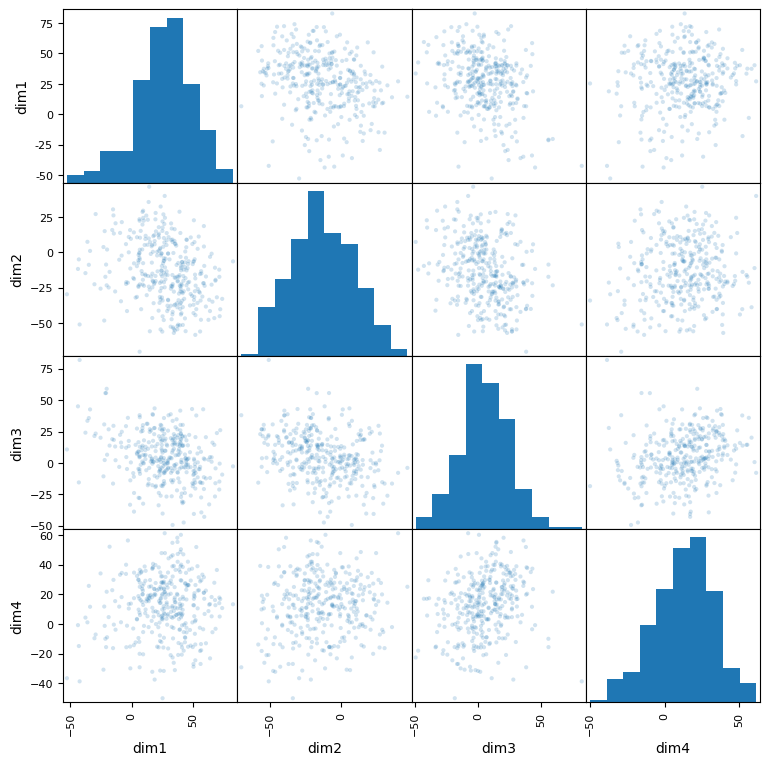

In [1771]:
sm2 = scatter_matrix(embeddings2[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

# Get the nearest neighbour

In [1772]:
# tests distance.euclidian
"""line1 = embeddings1.iloc[1,:]
line2 = embeddings1.iloc[2,:]
print(line1)
print(line2)

print(distance.euclidean(line1, line2))

embeddings1.apply(distance.euclidean, axis=1, args=[np.array(line1)])"""

'line1 = embeddings1.iloc[1,:]\nline2 = embeddings1.iloc[2,:]\nprint(line1)\nprint(line2)\n\nprint(distance.euclidean(line1, line2))\n\nembeddings1.apply(distance.euclidean, axis=1, args=[np.array(line1)])'

In [1773]:
# get the nearest neighbour of a line of the dataset df
# returns the label of the nn and its distance to the line
def get_nearest_neighbour(line, df, dist=distance.euclidean):
    idx = line.name
    df_without_line = df[df.index != idx]
    distances = df_without_line.apply(dist, axis=1, args=[np.array(line)]).to_frame()
    nn = distances.idxmin()[0]
    min_dist = distances[0][nn]
    return [nn, min_dist]

In [1774]:
# test the function
"""get_nearest_neighbour(line1, embeddings1)"""

'get_nearest_neighbour(line1, embeddings1)'

In [1775]:
# get the nearest neighbours and their distance for the first run

nearest_neighbours1 = embeddings1.apply(get_nearest_neighbour, axis=1, result_type='expand', 
                                          args=[embeddings1])
embeddings1['nn'] = nearest_neighbours1[0]
embeddings1['min_dist'] = nearest_neighbours1[1]
embeddings1

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,nn,min_dist
ID,,,,,,,,,,,,,,,,,,,,,
1-15LEHMI_t0,4.449478,16.748594,30.547764,-22.644270,-1.274597,2.111366,-3.990535,-8.236629,17.312319,37.839287,...,-0.993941,22.925644,21.371452,-24.576107,6.069017,-9.061858,-7.822943,11.512796,sub-active07_ses-pretraining_T1w,100.545223
1-17COLMA_t0,18.867954,34.619198,43.365326,-13.315820,-19.979673,-1.028698,10.715113,-21.144869,31.468853,25.399958,...,10.331023,4.210711,19.126980,2.603828,4.795332,-36.443768,-12.342142,4.611177,sub-active04_ses-pretraining_T1w,82.092198
1-18ROUCO_t0,43.891117,-28.639128,27.363247,-50.896614,-65.859910,-37.280550,-28.605593,-55.350660,5.856234,-0.820465,...,21.668514,-23.268236,-10.224967,66.876410,18.200440,-96.562730,23.159826,-11.909090,sub-active19_ses-pretraining_T1w,71.572889
1-40AYMJU_t0,-36.136720,28.177956,44.647650,-13.030479,35.706400,-10.065201,30.243128,7.380891,19.298256,31.531240,...,-8.312715,23.750488,19.525550,-32.370327,-19.745474,20.429413,-14.841233,15.225279,1-20FORHU_t0,91.233840
2-02FERMA_t0,-13.452292,3.432962,13.269778,27.949810,13.329447,32.925713,3.487422,38.613480,23.912290,-2.431128,...,-33.093185,9.888805,-61.765327,-11.859022,-35.447926,-1.889225,16.904398,-5.195408,nih_chp_04591_t1,77.730379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-inhibition10_ses-pretraining_T1w,40.921220,-13.255011,11.137449,-31.679438,-0.766285,42.759410,-43.193367,-25.045675,-6.606612,7.664353,...,27.013346,-40.239170,-13.224056,11.415318,29.492092,-77.471490,-18.074986,-15.016627,nih_chp_04266_t1,67.868164
sub-inhibition14_ses-pretraining_T1w,58.818850,-14.687035,-12.948108,6.177260,-15.626614,21.297905,-21.172325,-8.709175,-10.270523,-25.551888,...,49.616413,-65.609130,-4.338964,1.373754,20.245726,-37.202038,-20.480581,-5.587423,nih_chp_04145_t1,69.558587
sub-inhibition23_ses-pretraining_T1w,6.248565,-14.865083,5.281815,-16.317148,-20.182348,-51.815018,7.523934,-41.331463,35.634987,-16.634000,...,35.929253,-22.682050,34.864265,41.245380,18.669910,-43.759230,-1.582632,-2.507713,nih_chp_01967_t1,97.922743


In [1776]:
# get the nearest neighbours and their distance for the second run

nearest_neighbours2 = embeddings2.apply(get_nearest_neighbour, axis=1, result_type='expand',
                                          args=[embeddings2])
embeddings2['nn'] = nearest_neighbours2[0]
embeddings2['min_dist'] = nearest_neighbours2[1]
embeddings2

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,nn,min_dist
ID,,,,,,,,,,,,,,,,,,,,,
1-15LEHMI_t0,-1.206665,15.827519,-33.303960,-15.210158,1.836242,1.837260,51.745450,-17.978855,37.352430,-23.224953,...,-0.088227,7.761208,15.360495,-7.500472,-3.987021,-7.312024,-14.418289,-1.720728,sub-active07_ses-pretraining_T1w,96.126616
1-17COLMA_t0,42.593693,-12.168615,-47.455800,-17.990765,-8.944613,-5.527036,29.848604,9.914445,19.452660,-1.067441,...,-9.373775,-27.630991,42.426533,-12.157677,3.487030,-27.293703,-15.219179,-1.377311,nih_chp_00501_t1,98.499573
1-18ROUCO_t0,68.645935,-19.345404,-4.338029,-3.209188,-60.377987,-36.532253,3.262010,44.488117,10.981612,71.757790,...,16.372526,-35.746967,18.276808,-38.862144,-16.488924,-56.321053,-1.405207,12.109166,sub-active19_ses-pretraining_T1w,80.967537
1-40AYMJU_t0,-15.127944,30.438705,-16.458958,-16.272287,19.623579,37.993290,25.914501,-13.252512,8.292604,-41.066402,...,-7.844323,15.787667,7.147057,43.530468,34.358425,46.746930,25.532902,3.382737,sub-inhibition25_ses-pretraining_T1w,80.435159
2-02FERMA_t0,30.236805,10.812012,2.653700,44.371464,31.819912,-10.033415,-2.846956,-27.725473,2.396073,35.189323,...,29.968204,6.925604,17.346537,-2.239992,1.777474,15.291664,-2.924892,-11.892128,nih_chp_04591_t1,56.178100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-inhibition10_ses-pretraining_T1w,67.622590,-46.410088,14.388208,27.888918,-30.533650,-51.981464,8.962340,13.851637,14.303352,67.898170,...,-2.840049,11.751353,-1.708818,-20.601946,-25.351513,-33.033627,-8.072503,-12.607285,nih_chp_04939_t1,83.859167
sub-inhibition14_ses-pretraining_T1w,74.074480,-32.810474,-9.294836,10.804025,-16.233086,-23.862343,6.515368,-27.475178,4.241878,55.024036,...,4.601726,17.738327,2.482007,-36.311874,-58.251602,-44.319397,-39.158085,21.380060,nih_chp_04145_t1,72.925904
sub-inhibition23_ses-pretraining_T1w,23.124573,-31.476510,2.717686,-7.721288,-49.646225,-3.775683,6.202821,15.585203,-18.616290,-2.869785,...,7.601410,-20.795550,-9.217152,16.411026,9.241714,-52.234756,-12.917842,18.491385,nih_chp_01518_t1,103.683466


In [1777]:
# save embeddings 1 and 2 as csv files
"""embeddings1.to_csv("embeddings_05-10.csv")
embeddings2.to_csv("embeddings_05-11.csv")"""

'embeddings1.to_csv("embeddings_05-10.csv")\nembeddings2.to_csv("embeddings_05-11.csv")'

# Get distance matrices

In [1778]:
def get_distance_matrix(emb, verbose=False):
    # emb should not have the nn nor the min_dist columns    
    dist_mat = pd.DataFrame()

    for idx in emb.index:
        line = emb[emb.index == idx]
        if verbose:
            print(line)
        distances = emb.apply(distance.euclidean, axis=1, args=[np.array(line)])
        dist_mat[idx] = distances

    return dist_mat

In [1779]:
# reload the original files for them not to have the 'nn' and 'min_dist' columns
#embeddings1, embeddings2 = load_embeddings()

embedding_cols = ["dim"+str(i+1) for i in range(n_dims)]

# generate the distance matrices
dist_mat1 = get_distance_matrix(embeddings1[embedding_cols])
dist_mat2 = get_distance_matrix(embeddings2[embedding_cols])

# save the distance matrices
# dist_mat1.to_csv("distance_mat_05-10.csv")
# dist_mat2.to_csv("distance_mat_05-11.csv")

# NN analysis

In [1780]:
"""# load the tables with the 'nn' and 'min_dist' columns
embeddings1 = pd.read_csv("embeddings_05-10.csv", index_col=0)
embeddings2 = pd.read_csv("embeddings_05-11.csv", index_col=0)"""

'# load the tables with the \'nn\' and \'min_dist\' columns\nembeddings1 = pd.read_csv("embeddings_05-10.csv", index_col=0)\nembeddings2 = pd.read_csv("embeddings_05-11.csv", index_col=0)'

### Calculate the proportion of nn that are still nn in the other latent space

In [1781]:
def nearest_neighbours_conservation(emb1, emb2):
    # emb1 and emb2 should contain the nn column already
    if False in (emb1.index == emb2.index):
        raise ValueError("emb1 and emb2 should contain the same elements")
    else:
        same_nn = (emb1.nn == emb2.nn)
        return same_nn, same_nn.mean()
        

In [1782]:
same_nn, ratio = nearest_neighbours_conservation(embeddings1, embeddings2)
# ratio of vectors that keep their nn
print(same_nn.sum(),"elements,",ratio*100, "% of the dataset")


107 elements, 31.378299120234605 % of the dataset


In [1783]:
# list of vectors that keep their nn (+ their nn in the 2nd column)
embeddings1[same_nn != True]['nn']

ID
1-17COLMA_t0                            sub-active04_ses-pretraining_T1w
1-40AYMJU_t0                                                1-20FORHU_t0
2-04HEBTO_t0                                            nih_chp_03373_t1
2-14COEEN_t0                                                e0068_t1_s03
2-25MATMA_t0                                            nih_chp_01598_t1
                                                      ...               
sub-active10_ses-pretraining_T1w                        nih_chp_05234_t1
sub-active15_ses-pretraining_T1w                            1-18ROUCO_t0
sub-inhibition10_ses-pretraining_T1w                    nih_chp_04266_t1
sub-inhibition23_ses-pretraining_T1w                    nih_chp_01967_t1
sub-inhibition31_ses-pretraining_T1w                    nih_chp_04745_t1
Name: nn, Length: 234, dtype: object

### Visualisation of single nearest neighbour position in the other latent space

rand_idx nih_chp_02949_t1
nearest_neighbours: nih_chp_05192_t1 nih_chp_01604_t1

6.158357771260997%, 21-th element


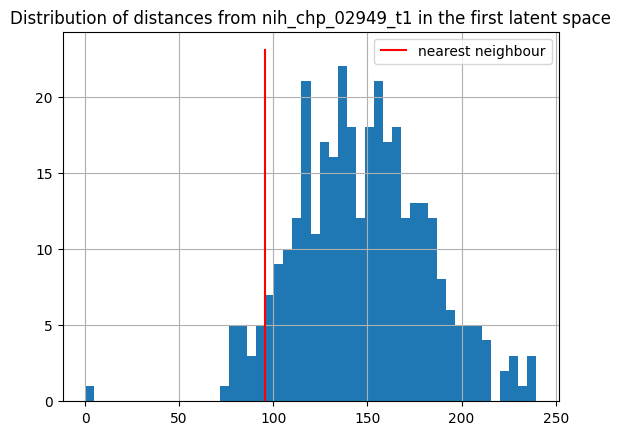

0.8797653958944281%, 3-th element


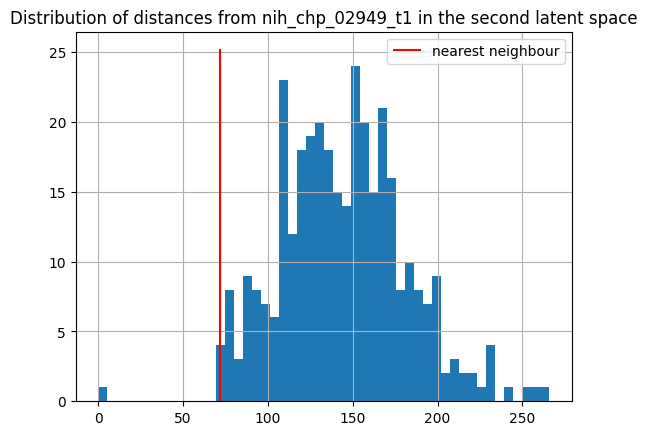

In [1784]:
# choose a random index
rand_idx = rd.choice(embeddings1.index)
print("rand_idx", rand_idx)

# get the nn of rand_idx for both latent spaces
nn1 = str(embeddings1.nn[rand_idx])
nn2 = str(embeddings2.nn[rand_idx])
print("nearest_neighbours:", nn1, nn2)
print()

# get the distances from rand_idx in the first latent space
dist2nn1 = dist_mat1[str(rand_idx)]
dist2nn1.hist(bins=50)
dist1 = dist2nn1[nn2]  # distance of nn2 in the first latent space
# calculate the percentile of dist(rand_idx, nn2) in the first latent space
percentile = percentileofscore(dist2nn1, dist1)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn1)/100)}-th element')
# plot the distance distribution
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist1, ymin=ymin, ymax=ymax, colors='red') # show position of nn in the other
                                                      # latent space
plt.title(f"Distribution of distances from {rand_idx} in the first latent space")
plt.legend(["nearest neighbour"])
plt.show()

# same thing for the second latent space (and nn1)
plt.figure()
dist2nn2 = dist_mat2[str(rand_idx)]
dist2nn2.hist(bins=50)
dist2 = dist2nn2[nn1]
percentile = percentileofscore(dist2nn2, dist2)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn2)/100)}-th element')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist2, ymin=ymin, ymax=ymax, colors='red')
plt.title(f"Distribution of distances from {rand_idx} in the second latent space")
plt.legend(["nearest neighbour"])
plt.show()

### Average percentile of nn in the other latent space

In [1785]:
def get_percentile(distance_distrib_a, embeddings_b):
# distance_distrib_a is the distance distribution of idx in the latent space a, ie a column 
# (or line) of the associated dist_mat
    idx = distance_distrib_a.name
    nn = embeddings_b.nn[idx] ## nn is the nearest neighbour of idx in the latent space b
    
    dist_a = distance_distrib_a[str(nn)]
    percentile = percentileofscore(distance_distrib_a, dist_a)
    
    return percentile

In [1786]:
# function test


distance_distrib = dist_mat1['1-03HUBJO_t0']  # pick an element
print(get_percentile(distance_distrib, embeddings2))

dist_mat1.apply(get_percentile, axis=0, args=[embeddings2])

2.6392961876832843


1-15LEHMI_t0                            0.586510
1-17COLMA_t0                            0.879765
1-18ROUCO_t0                            0.586510
1-40AYMJU_t0                            1.173021
2-02FERMA_t0                            0.586510
                                          ...   
sub-inhibition10_ses-pretraining_T1w    1.173021
sub-inhibition14_ses-pretraining_T1w    0.586510
sub-inhibition23_ses-pretraining_T1w    7.331378
sub-inhibition28_ses-pretraining_T1w    0.586510
sub-inhibition31_ses-pretraining_T1w    2.052786
Length: 341, dtype: float64

In [1787]:
def get_average_percentile(dist_mat1, dist_mat2, emb1, emb2):
# computes the average percentile a nn is sent to in the other latent space
    average_percentile_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2]).mean()
    average_percentile_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1]).mean()
    return (average_percentile_a + average_percentile_b) / 2

In [1788]:
average_percentile = get_average_percentile(dist_mat1, dist_mat2, embeddings1, embeddings2)
print(f'{average_percentile}%,', f'{average_percentile*550/100}-th element')

2.379150506101599%, 13.085327783558794-th element


### Position stats of nn in the other latent space

In [1789]:
def get_nn_stats(dist_mat1, dist_mat2, emb1, emb2):
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])
    mean_a = percentiles_a.mean()
    mean_b = percentiles_b.mean()
    std_a = percentiles_a.std()
    std_b = percentiles_b.std()
    
    percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
    med = percentiles.median()
    first_quartile = percentiles.quantile(0.25)
    third_quartile = percentiles.quantile(0.75)

    nn_stats = {'mean': (mean_a + mean_b) / 2,
                'standard deviation': (std_a + std_b) / 2,
                'median': med,
                'first quartile': first_quartile,
                'third quartile': third_quartile}
    
    return nn_stats


In [1790]:
get_nn_stats(dist_mat1, dist_mat2, embeddings1, embeddings2)

{'mean': 2.379150506101599,
 'standard deviation': 3.7606479924333134,
 'median': 1.1730205278592376,
 'first quartile': 0.5865102639296188,
 'third quartile': 2.565982404692082}

### Histogram of position of nn in the other latent space


In [1791]:
def get_percentile_histograms(dist_mat1, dist_mat2, emb1, emb2, separate=False,
                              show_average=False, show_median=True, vlines_width=0.5,
                              save_path=None):
    
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])

    if separate:
        # compute the histogram
        percentiles_a.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_a.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_a.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn2 in the latent space 1")

        plt.figure()
        percentiles_b.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_b.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_b.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn1 in the latent space 2")

    
    else:
        percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
        percentiles.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn in the other latent space")
        if save_path:
            plt.savefig(save_path)
    

12-13-53 2022-07-05
{'mean': 2.379150506101599, 'standard deviation': 3.7606479924333134, 'median': 1.1730205278592376, 'first quartile': 0.5865102639296188, 'third quartile': 2.565982404692082}


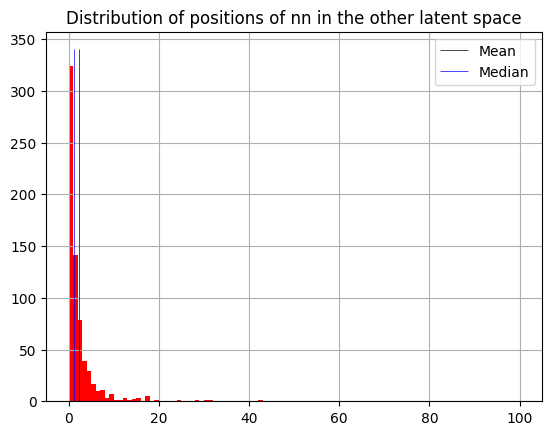

In [1792]:
#get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=True,
#show_average=True)

print(mod1, mod2)
fig_save_path = os.path.join(save_path, mod1+'_'+mod2+".png")
values_save_path = os.path.join(save_path, mod1+'_'+mod2+".txt")


plt.figure()
get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=False,
show_average=True, save_path=fig_save_path)

nn_stats = get_nn_stats(dist_mat1, dist_mat2, embeddings1, embeddings2)
print(nn_stats)


## save figure if wanted
if save_path:
    with open(values_save_path, 'w') as file:
        json.dump(nn_stats, file)

### Save the space nn distance for each model type and conditions

In [1796]:
# compute the mean score of all of them

saved_path = os.path.join(dir_path, "#performance_comparisons/nn")

mod_conds = [folder for folder in os.listdir(saved_path) if os.path.isdir(os.path.join(saved_path,folder))]

nn_mean = np.zeros((len(mod_conds)//2, 2))

for folder in mod_conds:
    j = 0 if 'convnet' in folder else 1
    if "no" in folder:
        i = 2
    else:
        i = 0
    if '4' in folder:
        i += 1
    
    median_values = []
    for file in os.listdir(os.path.join(saved_path,folder)):
        if 'txt' in file:

            with open(os.path.join(saved_path, folder, file), 'r') as file_txt:
                file_content = json.load(file_txt)
            median_values.append(file_content['median'])

    nn_mean[i,j] = np.mean(median_values)

df = pd.DataFrame(nn_mean, columns=['convnet', 'densenet2'], index=['foldlabel_30', 'foldlabel_4', 'no_foldlabel_30', 'no_foldlabel_4'])
df.to_csv(saved_path+'/mean_median_nn.csv')
df

,convnet,densenet2
foldlabel_30,3.189150,10.630499
foldlabel_4,41.788856,26.906158
no_foldlabel_30,1.282991,2.492669
no_foldlabel_4,39.809384,26.722874


### Plot nn distance function of classifier perfomances

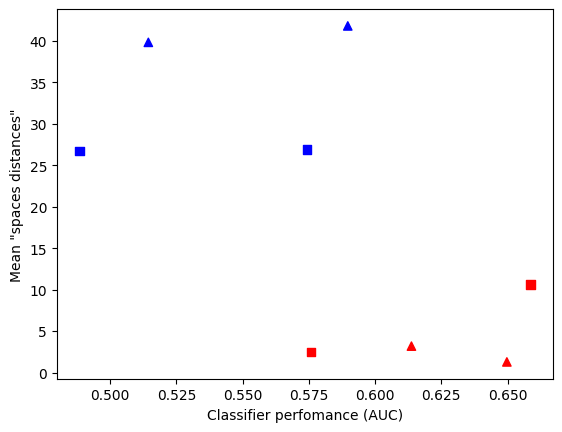

In [1799]:
# get the df (performance and nn distance)
saved_path = os.path.join(dir_path, "#performance_comparisons/nn")
nn_df = pd.read_csv(saved_path+'/mean_median_nn.csv', index_col=0)

perf_df = pd.read_csv(dir_path+'/#performance_comparisons/performance_comparison_5000.csv', index_col=0)


shapes = ['^', 's'] # each model type has a shape

# plot
for i,model_type in enumerate(nn_df.columns):
    X = perf_df[model_type].values
    Y = nn_df[model_type].values
    colors = ['r', 'b', 'r', 'b']

    plt.scatter(X, Y, color=colors, marker=shapes[i])


plt.xlabel("Classifier perfomance (AUC)")
plt.ylabel('Mean "spaces distances"')
plt.show()

# C'est le cancer pour faire une légende bien, alors : triangle == convnet, square == densenet2, red == dim 30, blue == dim 4

In [1800]:
perf_df

,convnet,densenet2,pca
foldlabel_30,0.613729,0.658608,0.593625
foldlabel_4,0.589703,0.574395,0.538784
no_foldlabel_30,0.649748,0.575910,0.593625
no_foldlabel_4,0.514435,0.488433,0.538784
